In [106]:
# Import required libraries
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import pandas as pd
from IPython.core.display import HTML
import numpy as np
%matplotlib inline
import glob
import readData
reload(readData) #avoid kernel restart if changed
import re
import databaseQuery
import matplotlib.dates as mdates

In [22]:
## Read in the data as a pandas dataframe
# Files should be .csv format in \Data\ subdirectory
# Files should be simply named SAGE_SOUTH or RIV_NORTH, without numerals
allFiles = glob.glob("Data\*.csv") #get all files with csv extension in this subfolder
print allFiles


#Return pandas dataframe with all the data, datetime index
#toggle saveCSV True/False to save a csv of the compiled data

voltage, radius = readData.readCSV(allFiles, saveCSV = False) 
## Read in the metadata as a pandas dataframe
metadata = pd.read_csv('PISTON_DENDROMETER_METADATA.csv',sep=',', dtype=str)

#Create dictionaries between sensor ID and metadata info
Site = dict(zip(metadata['Micron Displacement DSID'], metadata['Site'] )) 
Slope = dict(zip(metadata['Micron Displacement DSID'], metadata['Slope'] )) 
Species = dict(zip(metadata['Micron Displacement DSID'], metadata['Species'] )) 
Tree = dict(zip(metadata['Micron Displacement DSID'], metadata['Tree #'] )) 


['Data\\RIV_NORTH.csv', 'Data\\RIV_SOUTH.csv', 'Data\\SAGE_NORTH.csv', 'Data\\SAGE_SOUTH.csv']


In [23]:
Species

{'60000': 'QUGA',
 '60001': 'QUGA',
 '60002': 'QUGA',
 '60003': 'QUGA',
 '60004': 'QUGA',
 '60005': 'QUGA',
 '60006': 'QUGA',
 '60007': 'QUGA',
 '60008': 'QUGA',
 '60009': 'QUGA',
 '60010': 'ARME',
 '60011': 'ARME',
 '60012': 'QUCH',
 '60013': 'QUCH',
 '60014': 'ARME',
 '60015': 'ARME',
 '60016': 'NODE',
 '60017': 'NODE',
 '60018': 'PSME',
 '60019': 'PSME',
 '60020': 'PSME',
 '60021': 'PSME',
 '60022': 'NODE',
 '60023': 'NODE',
 '60024': 'NODE',
 '60025': 'NODE',
 '60026': 'ARME',
 '60027': 'ARME'}

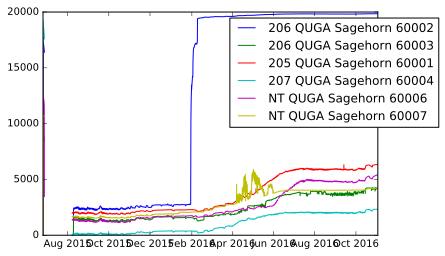

In [24]:
## IDENTIFY GOOD QUGA SENSORS
for column in radius:
    if Species[column]=='QUGA':
        
        plt.plot(radius.index, radius[column], 
#                  color=scalarMap.to_rgba(uniq.index(Tree[column])), 
                 label = (Tree[column] + ' ' + Species[column] + ' ' + Site[column]) + ' ' + column)
plt.legend(bbox_to_anchor=(1.2, 1))

#60002 (maybe), 60001, 60004,60006

In [25]:
#trim to desired sensors
goodSensors = radius[['60001', '60004', '60006']].copy()
#smooth
smoothed = goodSensors.rolling(window=4, center=True).mean()
#trim to start time
startDateTime = pd.to_datetime('2016-04-01 00:00:00')
stopDateTime = pd.to_datetime('2016-11-01 00:00:00')
radiusTR = smoothed[(pd.to_datetime(smoothed.index) > startDateTime) & 
                    (pd.to_datetime(smoothed.index) < stopDateTime)]
#zero initial radius
radiusMin = radiusTR.apply(np.min)
radiusZeroed =  radiusTR-radiusMin

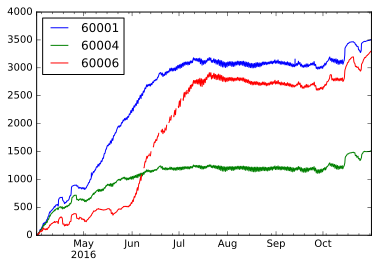

In [27]:
radiusZeroed.plot()
#Tree 60006's delayed growth may be attributed to its north-facing aspect; other two are north-facing
#add rain?

In [32]:
## Import from mySQL database 
#Convert datetime stamps to strings for the sql query
dateStart = str(startDateTime.year) + '-' + str(startDateTime.month) + '-' + str(startDateTime.day)
dateStop =  str(stopDateTime.year) + '-' + str(stopDateTime.month) + '-' + str(stopDateTime.day)

#here we make use of external .py file with odmquery function (thanks Collin!) to get data from the database
#1672 = cumulative WY precip, in mm
#1785 = Rainfall mm TB4 WSAM RWS_Rain_TB4_Tot2015-03-26 (ongoing)Rainfall mmAngelo Meadow WSwsam0 to 700TB4mm-L Rain Gage
#2958 = Barometric Pressure, WSSR, mBar
#2959 = Rainfall, WSSR, mm
#3048 = Rainfall Cumulative mm Sagehorn
rain = databaseQuery.odmquery(dateStart, dateStop, '2959', True)

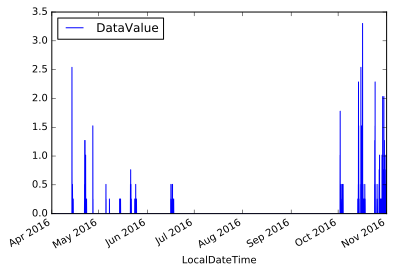

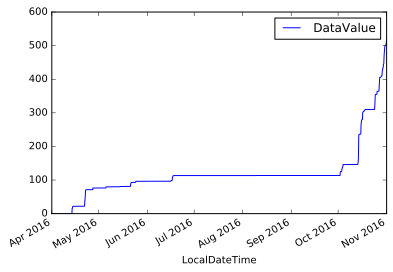

In [34]:
rain.plot()
cumsum = rain.cumsum()
cumsum.plot()

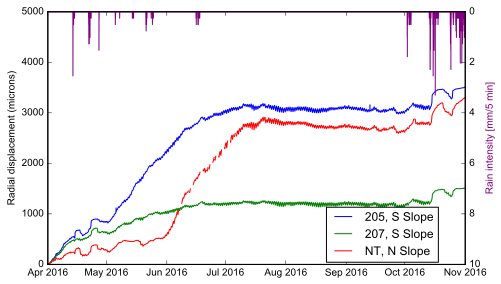

In [51]:
fig, ax = plt.subplots(1, 1, figsize=((19/2.54),(11.5/2.54)))
twin = ax.twinx()

for column in radiusZeroed:
    ax.plot(radiusZeroed.index, radiusZeroed[column], 
#                  color=scalarMap.to_rgba(uniq.index(Tree[column])), 
                 label = (Tree[column] + ', ' + Slope[column] + ' Slope'))
ax.legend(bbox_to_anchor=(.95, .25))
ax.set_ylabel('Radial displacement (microns)')
ax.set_ylim([0,5000])

twin.plot(rain.index,rain['DataValue'],c='purple')
twin.set_ylim([0,10])

twin.invert_yaxis()
twin.set_ylabel('Rain intensity [mm/5 min]', color='purple')

In [69]:
radiusZeroed.tail()

,60001,60004,60006
2016-10-31 21:30:00,3508.23,1507.51,3298.54
2016-10-31 22:00:00,3508.23,1507.52,3298.44
2016-10-31 22:30:00,3508.23,1507.53,3298.44
2016-10-31 23:00:00,3508.23,1507.54,3298.24
2016-10-31 23:30:00,3508.23,1507.55,3298.24


In [72]:
#normalize each day's values to 00:00 hours, if value exists at that time?
group_df = radiusZeroed.groupby(radiusZeroed.index.date)
group_df = group_df.aggregate({pd.np.min})
group_df.index = group_df.index.to_datetime()
dailyMin = group_df.resample('30min',fill_method='ffill')
dailyMin.head()

C:\Users\wjh\Anaconda\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill()


,60001,60004,60006
,amin,amin,amin
2016-04-01 00:00:00,0.0,0.0,0.0
2016-04-01 00:30:00,0.0,0.0,0.0
2016-04-01 01:00:00,0.0,0.0,0.0
2016-04-01 01:30:00,0.0,0.0,0.0
2016-04-01 02:00:00,0.0,0.0,0.0


In [79]:
daily.columns

Index([           u'60001',            u'60004',            u'60006',
       (u'60001', u'amin'), (u'60004', u'amin'), (u'60006', u'amin')],
      dtype='object')

In [84]:
daily=radiusZeroed.join(dailyMin)
daily['60001_dif'] = daily['60001']-daily['60001', 'amin']
daily['60004_dif'] = daily['60004']-daily['60004', 'amin']
daily['60006_dif'] = daily['60006']-daily['60006', 'amin']
dailyZeroed = daily[['60001_dif', '60004_dif', '60006_dif']].copy()


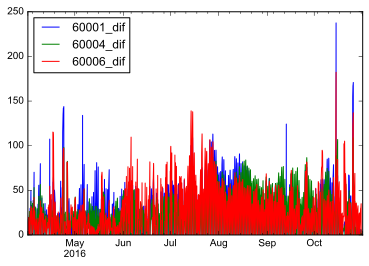

In [85]:
dailyZeroed.plot()

In [86]:
#

#Take the average across all sensors, ignoring NaNs 
allTogether = dailyZeroed.mean(axis=1).to_frame()
allTogether.columns=['dailyZeroed']


In [87]:
allTogether["time"] = allTogether.index.time
allTogether['date'] = allTogether.index.date

In [88]:
allTogether.tail()

,dailyZeroed,time,date
2016-10-31 21:30:00,NaN,21:30:00,2016-10-31
2016-10-31 22:00:00,NaN,22:00:00,2016-10-31
2016-10-31 22:30:00,NaN,22:30:00,2016-10-31
2016-10-31 23:00:00,NaN,23:00:00,2016-10-31
2016-10-31 23:30:00,NaN,23:30:00,2016-10-31


In [89]:
april2016 = allTogether[
    (allTogether.index > pd.to_datetime('2016-04-01 00:00:00')) &
    (allTogether.index < pd.to_datetime('2016-05-01 00:00:00'))]
may2016 = allTogether[
    (allTogether.index > pd.to_datetime('2016-05-01 00:00:00')) &
    (allTogether.index < pd.to_datetime('2016-06-01 00:00:00'))]
june2016 = allTogether[
    (allTogether.index > pd.to_datetime('2016-06-01 00:00:00')) &
    (allTogether.index < pd.to_datetime('2016-07-01 00:00:00'))]
july2016 = allTogether[
    (allTogether.index > pd.to_datetime('2016-07-01 00:00:00')) &
    (allTogether.index < pd.to_datetime('2016-08-01 00:00:00'))]
august2016 = allTogether[
    (allTogether.index > pd.to_datetime('2016-08-01 00:00:00')) &
    (allTogether.index < pd.to_datetime('2016-09-01 00:00:00'))]
september2016 = allTogether[
    (allTogether.index > pd.to_datetime('2016-09-01 00:00:00')) &
    (allTogether.index < pd.to_datetime('2016-10-01 00:00:00'))]
october2016 = allTogether[
    (allTogether.index > pd.to_datetime('2016-10-01 00:00:00')) &
    (allTogether.index < pd.to_datetime('2016-11-01 00:00:00'))]


In [90]:
# example from http://nipunbatra.github.io/2015/06/timeseries/
daily_radius = pd.pivot_table(allTogether, index=["time"], columns=["date"], values=["dailyZeroed"])

April = pd.pivot_table(april2016, index=["time"], columns=["date"], values=["dailyZeroed"])

May = pd.pivot_table(may2016, index=["time"], columns=["date"], values=["dailyZeroed"])

June = pd.pivot_table(june2016, index=["time"], columns=["date"], values=["dailyZeroed"])

July = pd.pivot_table(july2016, index=["time"], columns=["date"], values=["dailyZeroed"])

August = pd.pivot_table(august2016, index=["time"], columns=["date"], values=["dailyZeroed"])

September = pd.pivot_table(september2016, index=["time"], columns=["date"], values=["dailyZeroed"])

October = pd.pivot_table(october2016, index=["time"], columns=["date"], values=["dailyZeroed"])


In [91]:
#Resulting 'month' dataframe has half-hourly time of day for index (rows), 
# and each column is a single day of the month
April.head()

dailyZeroed                                                         \
date      2016-04-01 2016-04-02 2016-04-03 2016-04-04 2016-04-05 2016-04-06   
time                                                                          
00:00:00         NaN   0.000000   0.000000   0.000000   2.036667   3.566667   
00:30:00    0.000000   1.340000   2.126667   1.400000   4.106667   4.620000   
01:00:00    0.790000   2.643333   4.053333   2.673333   6.056667   5.676667   
01:30:00    1.720000   3.840000   5.850000   3.933333   8.056667   6.716667   
02:00:00    2.506667   4.910000   7.683333   5.406667   9.993333   7.800000   

                                                        ...                 \
date     2016-04-07 2016-04-08 2016-04-09 2016-04-10    ...     2016-04-21   
time                                                    ...                  
00:00:00   0.000000   0.000000   0.000000   0.000000    ...       0.646667   
00:30:00   1.233333   1.460000   1.490000   1.076667    ...       1.256667   
01:00:00   2.366667   3.040000   3.150000   2.210000    ...       1.766667   
01:30:00   3.526667   4.533333   4.836667   3.356667    ...       2.226667   
02:00:00   4.663333   6.003333   6.523333   4.620000    ...       2.523333   

                                                                            \
date     2016-04-22 2016-04-23 2016-04-24 2016-04-25 2016-04-26 2016-04-27   
time                                                                         
00:00:00       0.00   0.000000   0.200000   0.406667  60.526667  23.523333   
00:30:00       1.76   5.473333   0.356667   0.516667  60.606667  23.683333   
01:00:00       3.52  11.083333   0.570000   0.586667  60.706667  23.823333   
01:30:00       5.09  19.803333   0.563333   0.616667  60.730000  23.983333   
02:00:00       6.61  30.196667   0.523333   0.623333  60.746667  24.140000   

                                           
date     2016-04-28 2016-04-29 2016-04-30  
time                                       
00:00:00   1.186667      23.21  12.773333  
00:30:00   1.323333      23.46  13.573333  
01:00:00   1.416667      23.83  14.316667  
01:30:00   1.500000      24.17  14.916667  
02:00:00   1.430000      24.46  15.583333  

[5 rows x 30 columns]

In [92]:
#now, average all days of month into one day
April = April.mean(axis=1).to_frame()
May = May.mean(axis=1).to_frame()
June = June.mean(axis=1).to_frame()
July = July.mean(axis=1).to_frame()
August = August.mean(axis=1).to_frame()
September = September.mean(axis=1).to_frame()
October = October.mean(axis=1).to_frame()

In [93]:
months = [April, May, June, July, August, September, October]
April.name = 'April'
May.name = 'May'
June.name = 'June'
July.name = 'July'
August.name = 'August'
September.name = 'September'
October.name = 'October'

In [94]:
for month in months:
    month = pd.DataFrame(month)


In [99]:
for month in months:
#     month['DAY'] = date.today()
    month['TIME'] = month.index
    month['datetime']=month.apply(lambda x: x['TIME'], axis=1)

In [100]:
all_linestyles=['solid', 'dashed', 'dashdot', 'dotted', #(0, (2.0, 4.0)),(0, (4.0, 2.0)),(0, (1.0, 3.0))]
                'solid', 'dashed', 'dotted']
month_names = ['April','May','June','July','August','September','October']
linestyles = all_linestyles[0:len(months)]
month_linestyle =  dict(zip(month_names, linestyles))

In [114]:
for month in months:
    month[0] = month[0]-month[0].iloc[0]

(0.0, 84600.0)

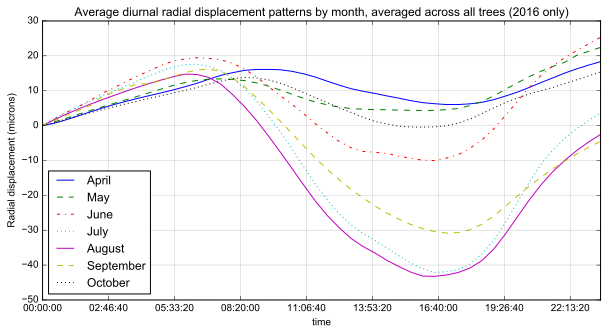

In [120]:
plt.figure(figsize=(10,5))
for month in months:
    ax = plt.plot(month.index, month[0], label=month.name,
                  linestyle = month_linestyle[month.name])
plt.legend(loc='lower left')
plt.grid(ls='solid', alpha=0.2)
plt.ylabel('Radial displacement (microns)')
plt.title('Average diurnal radial displacement patterns by month, averaged across all trees (2016 only)')
plt.xlim([min(April['datetime']),max(April['datetime'])])
#plt.locator_params(axis='x',nbins=13)

#plt.gca().xlim([0,1])
#plt.xlim([min(April.index),datetime.time(23)])


# plt.gca().xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,24,2)))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# plt.savefig('Plots\Diurnal_Sapflow_Patterns_By_Month.pdf')

#maximum (switch from sink to source of water) shifts with earlier sunrise
#earlier months show net positive daily growth
#amplitude increases later in season - greater reliance on stored water. greater
